# EDA

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
DATA_PATH = os.path.join("..", "data", "interim", "transactions.csv")
TARGET_PATH = os.path.join("..", "data", "raw", "beeline_antispam_hakaton_id_samples.csv")

COLORS = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:gray"]

## Подгрузка основного массива данных

In [3]:
data = pd.read_csv(
    DATA_PATH,
    dtype={
        "time_zone": "int8",
        "forward": "int8",
        "zero_call_flg": "int8",
        "source_b": "int8",
        "source_f": "int8",
        "num_b_length": "int8",
        "duration": "int16",
    },
    parse_dates=["datetime"],
)
data.head()

,id_a,id_b,time_zone,duration,forward,zero_call_flg,source_b,source_f,num_b_length,datetime
0,67596082,43588153,3,0,0,3,0,1,10,2021-11-01 18:43:03
1,4024969,67656553,4,206,0,5,1,0,10,2021-11-01 11:43:20
2,43166780,31861625,0,5,0,0,0,1,10,2021-11-01 10:32:36
3,51817902,41201237,3,0,0,0,0,1,10,2021-11-01 13:45:02
4,41812796,4932754,0,0,0,5,0,1,10,2021-11-01 13:53:12


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267702661 entries, 0 to 267702660
Data columns (total 10 columns):
 #   Column         Dtype         
---  ------         -----         
 0   id_a           int64         
 1   id_b           int64         
 2   time_zone      int8          
 3   duration       int16         
 4   forward        int8          
 5   zero_call_flg  int8          
 6   source_b       int8          
 7   source_f       int8          
 8   num_b_length   int8          
 9   datetime       datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int64(2), int8(6)
memory usage: 8.0 GB


## Подгрузка целевой переменной и train/test разбивки

In [5]:
targets = pd.read_csv(TARGET_PATH, usecols=["id", "target"])
targets["target"] = (
    targets["target"]
    .replace({
        np.NaN: "test",
        0.: "не спам",
        1.: "небольшие полезные ИП / малые бизнесы",
        2.: "организации",
        3.: "мобильная карусель",
        4.: "чёрные спаммеры и мошенники",
    })
    .astype("category")
)
targets.head()

,id,target
0,196535,test
1,63075900,организации
2,35233935,организации
3,23557360,чёрные спаммеры и мошенники
4,78926486,test


In [6]:
targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46235 entries, 0 to 46234
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   id      46235 non-null  int64   
 1   target  46235 non-null  category
dtypes: category(1), int64(1)
memory usage: 406.7 KB


## Анализ распределения исходящих звоноков по дням и целевым классам

In [7]:
data = (
    data
    .merge(targets, left_on="id_a", right_on="id", how="right")
    .drop(columns="id")
    .rename(columns={"target": "target_a"})
)
data.head()

,id_a,id_b,time_zone,duration,forward,zero_call_flg,source_b,source_f,num_b_length,datetime,target_a
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,test
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,организации
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,организации
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,чёрные спаммеры и мошенники
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,test


In [8]:
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267713480 entries, 0 to 267713479
Data columns (total 11 columns):
 #   Column         Non-Null Count      Dtype         
---  ------         --------------      -----         
 0   id_a           267702661 non-null  float64       
 1   id_b           267702661 non-null  float64       
 2   time_zone      267702661 non-null  float64       
 3   duration       267702661 non-null  float64       
 4   forward        267702661 non-null  float64       
 5   zero_call_flg  267702661 non-null  float64       
 6   source_b       267702661 non-null  float64       
 7   source_f       267702661 non-null  float64       
 8   num_b_length   267702661 non-null  float64       
 9   datetime       267702661 non-null  datetime64[ns]
 10  target_a       267713480 non-null  category      
dtypes: category(1), datetime64[ns](1), float64(9)
memory usage: 20.2 GB


C:\Users\karinoizerr\AppData\Local\Temp\ipykernel_26116\3102003440.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped =  data.groupby([pd.Grouper(key="datetime", freq="D"), "target_a"])["time_zone"].count().unstack()
C:\Users\karinoizerr\AppData\Local\Temp\ipykernel_26116\3102003440.py:21: FutureWarning: DatetimeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  axes[-1].set_xticklabels(grouped.index.format(), rotation=90)


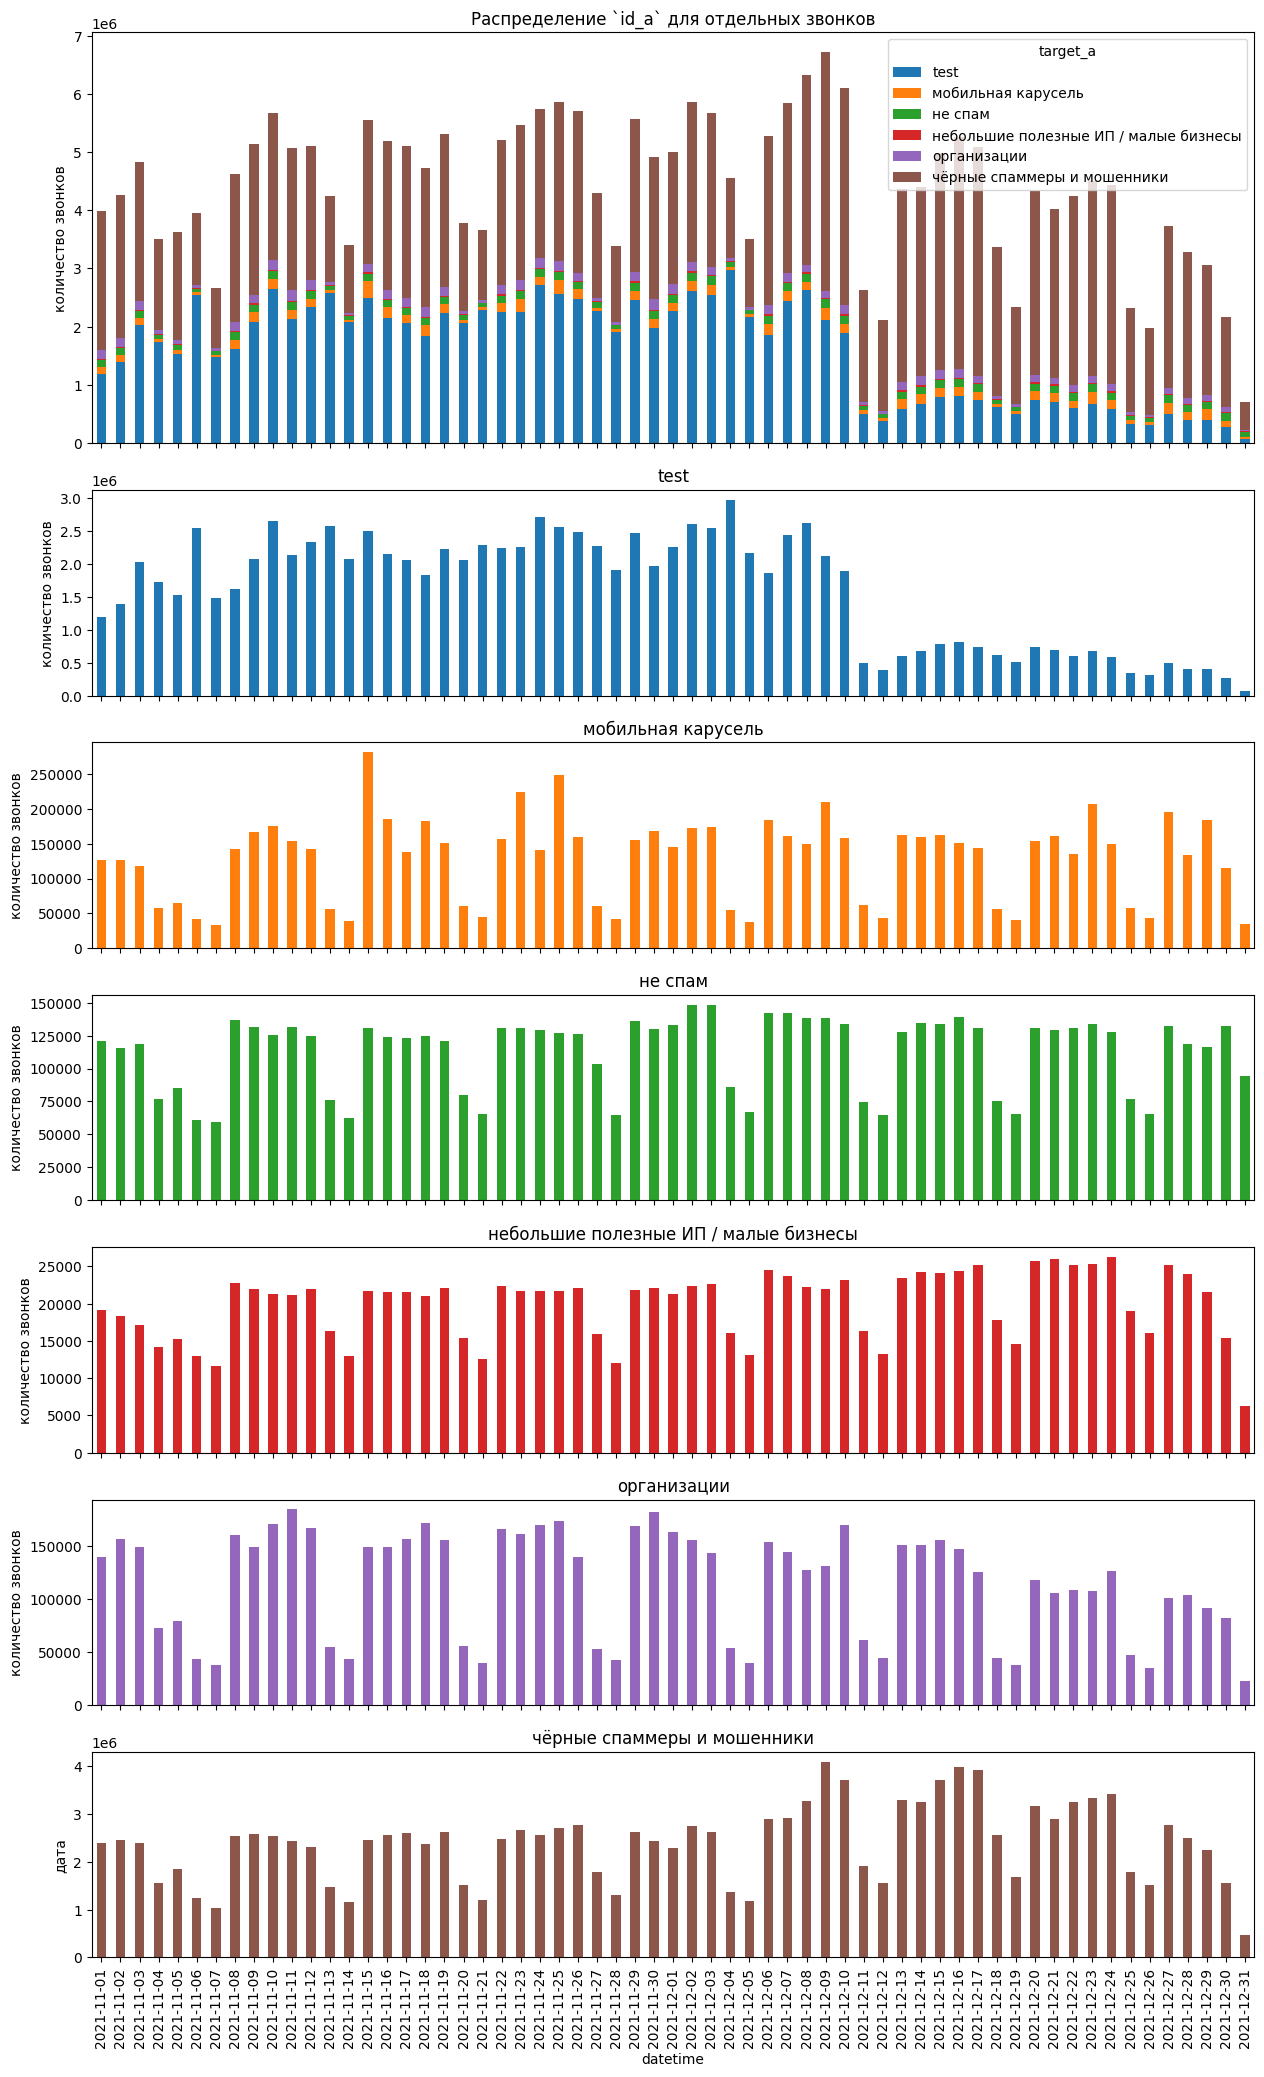

In [9]:
grouped =  (
    data
    .groupby([pd.Grouper(key="datetime", freq="D"), "target_a"])["time_zone"]
    .count()
    .unstack()
)

fig, axes = plt.subplots(
    7, 1,
    figsize=(15, 25),
    gridspec_kw={"height_ratios": [2, 1, 1, 1, 1, 1, 1]},
    sharex=True,
)

grouped.plot(
    kind="bar",
    stacked=True,
    color=COLORS,
    title="Распределение `id_a` для отдельных звонков",
    ax=axes[0],
)
for ax, label, color in zip(axes[1:], grouped.columns, COLORS):
    grouped[label].plot(kind="bar", color=color, title=label, ax=ax)
for ax in axes:
    ax.set(ylabel="количество звонков")
axes[-1].set_xticklabels(grouped.index.format(), rotation=90)
axes[-1].set_ylabel("дата")

plt.show()

# Пока здесь

In [10]:
for i in ["id", "target", "split"]:
    del data[i]

KeyError: 'id'

In [ ]:
data = data.merge(targets, left_on="id_b", right_on="id", how="right")
data.head()

In [ ]:
data["quasi_target_b"] = data.apply(gen_quasi_target, axis=1)

In [ ]:
grouped = (
    data
    .groupby([pd.Grouper(key="datetime", freq="D"), "quasi_target_b"])["time_zone"]
    .count()
    .unstack()
)

fig, ax = plt.subplots(figsize=(15, 6))

grouped.plot(
    kind="bar",
    stacked=True,
    rot=90,
    title="Распределение id_b для отдельных звонков",
    ax=ax,
)
ax.set(xlabel="дата", xticklabels=grouped.index.format(), ylabel="количество звонков")
ax.legend(title=None)

plt.show()

In [ ]:
for i in ["id", "target", "split"]:
    del data[i]